In [ ]:
import cv2
import time
import numpy as np
import tensorflow as tf

# CONFIG
TFLITE_MODEL = "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8s_rdd2022_2class7/weights/best_int8.tflite"
VIDEO_PATH = "/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4"
IMG_SIZE = 640
NUM_WARMUP = 20        # frames (do not count)
MAX_FRAMES = 300       # cap for faster testing

print("Loading TFLite INT8 model...")

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Quantization params
input_scale, input_zero_point = input_details[0]["quantization"]

print("Input dtype:", input_details[0]["dtype"])
print("Input quantization:", input_scale, input_zero_point)

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video"

frame_count = 0
timings = []

print("\n Running INT8 inference benchmark...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    # Preprocess
    img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Quantize input
    img = img / input_scale + input_zero_point
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)

    start = time.perf_counter()
    interpreter.invoke()
    end = time.perf_counter()

    if frame_count > NUM_WARMUP:
        timings.append(end - start)

cap.release()

# RESULTS
total_frames = len(timings)
avg_time = sum(timings) / total_frames
avg_fps = 1.0 / avg_time

print("\n========== RESULTS ==========")
print(f"Frames measured : {total_frames}")
print(f"Avg latency     : {avg_time*1000:.2f} ms")
print(f"Avg FPS         : {avg_fps:.2f}")
print("================================")


2026-02-07 10:39:19.300372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-07 10:39:19.308246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770440959.317449   26668 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770440959.320196   26668 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770440959.327124   26668 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

▶ Loading TFLite INT8 model...
Input dtype: <class 'numpy.uint8'>
Input quantization: 0.003921568859368563 0

▶ Running INT8 inference benchmark...


/home/saber/GitHub/road_anomaly_detection/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



========== RESULTS ==========
Frames measured : 280
Avg latency     : 74.70 ms
Avg FPS         : 13.39


In [ ]:
import cv2
import time
import numpy as np
import tensorflow as tf

# CONFIG
TFLITE_MODEL = "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8s_rdd2022_2class7/weights/best_int8.tflite"
VIDEO_PATH = "/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4"

MODEL_IMG_SIZE = 640          # YOLO input
VIDEO_DECODE_WIDTH = 960      # ⬅️ LOWER than 1920
VIDEO_DECODE_HEIGHT = 540

NUM_WARMUP = 20
MAX_FRAMES = 300

print("▶ Loading TFLite INT8 model...")

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]

print("Input dtype:", input_details[0]["dtype"])
print("Input quantization:", input_scale, input_zero_point)

# Video capture with reduced resolution
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video"

cap.set(cv2.CAP_PROP_FRAME_WIDTH, VIDEO_DECODE_WIDTH)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, VIDEO_DECODE_HEIGHT)

frame_count = 0
timings = []

print("\n▶ Running INT8 inference benchmark (downscaled decode)...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    # Preprocess
    img = cv2.resize(frame, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Quantize
    img = img / input_scale + input_zero_point
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)

    start = time.perf_counter()
    interpreter.invoke()
    end = time.perf_counter()

    if frame_count > NUM_WARMUP:
        timings.append(end - start)

cap.release()

# RESULTS
total_frames = len(timings)
avg_time = sum(timings) / total_frames
avg_fps = 1.0 / avg_time

print("\n========== RESULTS ==========")
print(f"Frames measured : {total_frames}")
print(f"Avg latency     : {avg_time*1000:.2f} ms")
print(f"Avg FPS         : {avg_fps:.2f}")
print("================================")


▶ Loading TFLite INT8 model...
Input dtype: <class 'numpy.uint8'>
Input quantization: 0.003921568859368563 0

▶ Running INT8 inference benchmark (downscaled decode)...

========== RESULTS ==========
Frames measured : 280
Avg latency     : 75.17 ms
Avg FPS         : 13.30


In [1]:
import cv2
import time
import numpy as np
import tensorflow as tf

# ================= CONFIG =================
TFLITE_MODEL = "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8s_rdd2022_2class7/weights/best_int8.tflite"
VIDEO_PATH = "/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4"
OUTPUT_VIDEO = "../../../runs/tflite/output_predictions.mp4"

MODEL_IMG_SIZE = 640
VIDEO_DECODE_WIDTH = 960
VIDEO_DECODE_HEIGHT = 540

CONF_THRESH = 0.25
NUM_WARMUP = 20
MAX_FRAMES = 300

CLASS_NAMES = {
    0: "Road Defect",
    1: "Pothole"
}

# ================= LOAD MODEL =================
print("▶ Loading TFLite INT8 model...")

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]

# ================= VIDEO SETUP =================
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video"

cap.set(cv2.CAP_PROP_FRAME_WIDTH, VIDEO_DECODE_WIDTH)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, VIDEO_DECODE_HEIGHT)

fps = cap.get(cv2.CAP_PROP_FPS)

writer = cv2.VideoWriter(
    OUTPUT_VIDEO,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (VIDEO_DECODE_WIDTH, VIDEO_DECODE_HEIGHT)
)

frame_count = 0
timings = []

print("\n▶ Running inference + saving output video...")

# ================= INFERENCE LOOP =================
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    orig_h, orig_w = frame.shape[:2]

    # ---------- PREPROCESS ----------
    img = cv2.resize(frame, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    img = img / input_scale + input_zero_point
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)

    start = time.perf_counter()
    interpreter.invoke()
    end = time.perf_counter()

    if frame_count > NUM_WARMUP:
        timings.append(end - start)

    # ---------- POSTPROCESS ----------
    output = interpreter.get_tensor(output_details[0]["index"])[0]
    output = output.transpose(1, 0)   # (8400, 6)


    for det in output:
        x1, y1, x2, y2, score, cls = det

        if score < CONF_THRESH:
            continue

        cls = int(cls)

        # Scale boxes back to original frame
        x1 = int(x1 * orig_w / MODEL_IMG_SIZE)
        x2 = int(x2 * orig_w / MODEL_IMG_SIZE)
        y1 = int(y1 * orig_h / MODEL_IMG_SIZE)
        y2 = int(y2 * orig_h / MODEL_IMG_SIZE)

        label = f"{CLASS_NAMES.get(cls, 'Unknown')} {score:.2f}"

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            frame,
            label,
            (x1, max(20, y1 - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )

    writer.write(frame)

cap.release()
writer.release()

# ================= RESULTS =================
avg_time = sum(timings) / len(timings)
avg_fps = 1.0 / avg_time

print("\n========== RESULTS ==========")
print(f"Frames measured : {len(timings)}")
print(f"Avg latency     : {avg_time*1000:.2f} ms")
print(f"Avg FPS         : {avg_fps:.2f}")
print(f"Saved video     : {OUTPUT_VIDEO}")
print("================================")


2026-02-10 14:11:31.277940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-10 14:11:31.413463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770712891.480986    8365 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770712891.500653    8365 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770712891.623689    8365 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

▶ Loading TFLite INT8 model...

▶ Running inference + saving output video...


/home/saber/GitHub/road_anomaly_detection/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



========== RESULTS ==========
Frames measured : 280
Avg latency     : 181.14 ms
Avg FPS         : 5.52
Saved video     : ../../../runs/tflite/output_predictions.mp4


In [2]:
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video"

ret, test_frame = cap.read()
assert ret, "Could not read first frame"

FRAME_H, FRAME_W = test_frame.shape[:2]

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # rewind video

True

In [3]:
writer = cv2.VideoWriter(
    OUTPUT_VIDEO.replace(".mp4", ".avi"),
    cv2.VideoWriter_fourcc(*"XVID"),
    fps,
    (FRAME_W, FRAME_H)
)

assert writer.isOpened(), "❌ VideoWriter failed to open"

In [2]:
print("Output details:", output_details)

Output details: [{'name': 'PartitionedCall:0', 'index': 419, 'shape': array([   1,    6, 8400], dtype=int32), 'shape_signature': array([   1,    6, 8400], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (2.5373830795288086, 0), 'quantization_parameters': {'scales': array([2.537383], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [3]:
print("Output shape:", output.shape)
print("One detection vector length:", output[0].shape)

Output shape: (6, 8400)
One detection vector length: (8400,)


In [4]:
import cv2
import time
import numpy as np
import tensorflow as tf
import os

# ================= CONFIG =================
TFLITE_MODEL = "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8s_rdd2022_2class7/weights/best_int8.tflite"
VIDEO_PATH = "/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4"
OUTPUT_VIDEO = "../../../runs/tflite/output_predictions.avi"

MODEL_IMG_SIZE = 640
CONF_THRESH = 0.25
NUM_WARMUP = 20
MAX_FRAMES = 300

CLASS_NAMES = {
    0: "Road Defect",
    1: "Pothole"
}

# ================= LOAD MODEL =================
print("▶ Loading TFLite INT8 model...")

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]

# ================= VIDEO SETUP =================
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "❌ Could not open input video"

# Read first frame to get REAL resolution
ret, first_frame = cap.read()
assert ret, "❌ Could not read first frame"

FRAME_H, FRAME_W = first_frame.shape[:2]
fps = cap.get(cv2.CAP_PROP_FPS)

# Reset video to first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Create output directory if needed
os.makedirs(os.path.dirname(OUTPUT_VIDEO), exist_ok=True)

# Safe codec for Linux / Raspberry Pi
writer = cv2.VideoWriter(
    OUTPUT_VIDEO,
    cv2.VideoWriter_fourcc(*"XVID"),
    fps,
    (FRAME_W, FRAME_H)
)

assert writer.isOpened(), "❌ VideoWriter failed to open"

print(f"▶ Saving output video: {OUTPUT_VIDEO}")
print(f"▶ Resolution: {FRAME_W}x{FRAME_H}, FPS: {fps:.2f}")

# ================= INFERENCE LOOP =================
frame_count = 0
timings = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    orig_h, orig_w = frame.shape[:2]

    # ---------- PREPROCESS ----------
    img = cv2.resize(frame, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Quantize to INT8
    img = img / input_scale + input_zero_point
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)

    start = time.perf_counter()
    interpreter.invoke()
    end = time.perf_counter()

    if frame_count > NUM_WARMUP:
        timings.append(end - start)

    # ---------- POSTPROCESS ----------
    output = interpreter.get_tensor(output_details[0]["index"])[0]
    output = output.transpose(1, 0)  # (8400, 6)

    for det in output:
        cx, cy, w, h, conf, cls = det

        conf = conf / 255.0  # INT8 → float
        if conf < CONF_THRESH:
            continue

        cls = int(cls)

        # Convert center → corner
        x1 = int((cx - w / 2) * orig_w / MODEL_IMG_SIZE)
        y1 = int((cy - h / 2) * orig_h / MODEL_IMG_SIZE)
        x2 = int((cx + w / 2) * orig_w / MODEL_IMG_SIZE)
        y2 = int((cy + h / 2) * orig_h / MODEL_IMG_SIZE)

        # Clamp to image bounds
        x1 = max(0, min(x1, orig_w - 1))
        y1 = max(0, min(y1, orig_h - 1))
        x2 = max(0, min(x2, orig_w - 1))
        y2 = max(0, min(y2, orig_h - 1))

        label = f"{CLASS_NAMES.get(cls, 'Unknown')} {conf:.2f}"

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            frame,
            label,
            (x1, max(20, y1 - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )

    # ---------- WRITE FRAME ----------
    writer.write(frame)

# ================= CLEANUP =================
cap.release()
writer.release()

# ================= RESULTS =================
if timings:
    avg_time = sum(timings) / len(timings)
    avg_fps = 1.0 / avg_time
else:
    avg_fps = 0.0

print("\n========== RESULTS ==========")
print(f"Frames processed : {frame_count}")
print(f"Avg FPS (model)  : {avg_fps:.2f}")
print(f"Output file     : {OUTPUT_VIDEO}")
print(f"File size       : {os.path.getsize(OUTPUT_VIDEO) / 1e6:.2f} MB")
print("================================")


▶ Loading TFLite INT8 model...
▶ Saving output video: ../../../runs/tflite/output_predictions.avi
▶ Resolution: 1920x1080, FPS: 24.00

========== RESULTS ==========
Frames processed : 301
Avg FPS (model)  : 4.47
Output file     : ../../../runs/tflite/output_predictions.avi
File size       : 40.93 MB


In [20]:
import cv2
import time
import numpy as np
import tensorflow as tf
import os

# ================= CONFIG =================
TFLITE_MODEL = "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite"
VIDEO_PATH = "/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4"
OUTPUT_VIDEO = "../../../runs/tflite/output_predictions.avi"

MODEL_IMG_SIZE = 320
CONF_THRESH = 0.01
NUM_WARMUP = 20
MAX_FRAMES = 300

CLASS_NAMES = {
    0: "Road Defect",
    1: "Pothole"
}

# ================= LOAD MODEL =================
print("▶ Loading TFLite INT8 model...")

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]

# ================= VIDEO SETUP =================
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "❌ Could not open input video"

# Read first frame to get REAL resolution
ret, first_frame = cap.read()
assert ret, "❌ Could not read first frame"

FRAME_H, FRAME_W = first_frame.shape[:2]
fps = cap.get(cv2.CAP_PROP_FPS)

# Reset video to first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Create output directory if needed
os.makedirs(os.path.dirname(OUTPUT_VIDEO), exist_ok=True)

# Safe codec for Linux / Raspberry Pi
writer = cv2.VideoWriter(
    OUTPUT_VIDEO,
    cv2.VideoWriter_fourcc(*"XVID"),
    fps,
    (FRAME_W, FRAME_H)
)

assert writer.isOpened(), "❌ VideoWriter failed to open"

print(f"▶ Saving output video: {OUTPUT_VIDEO}")
print(f"▶ Resolution: {FRAME_W}x{FRAME_H}, FPS: {fps:.2f}")

# ================= INFERENCE LOOP =================
frame_count = 0
timings = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    orig_h, orig_w = frame.shape[:2]

    # ---------- PREPROCESS ----------
    img = cv2.resize(frame, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Quantize to INT8
    img = img / input_scale + input_zero_point
    img = np.clip(img, 0, 255).astype(np.int8)
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)

    start = time.perf_counter()
    interpreter.invoke()
    end = time.perf_counter()

    if frame_count > NUM_WARMUP:
        timings.append(end - start)

    # ---------- POSTPROCESS ----------
    output = interpreter.get_tensor(output_details[0]["index"])[0]
    output = output.transpose(1, 0)  # (8400, 6)

    for det in output:
        cx, cy, w, h, conf, cls = det

        conf = conf / 255.0  # INT8 → float
        if conf < CONF_THRESH:
            continue

        cls = int(cls)

        # Convert center → corner
        x1 = int((cx - w / 2) * orig_w / MODEL_IMG_SIZE)
        y1 = int((cy - h / 2) * orig_h / MODEL_IMG_SIZE)
        x2 = int((cx + w / 2) * orig_w / MODEL_IMG_SIZE)
        y2 = int((cy + h / 2) * orig_h / MODEL_IMG_SIZE)

        # Clamp to image bounds
        x1 = max(0, min(x1, orig_w - 1))
        y1 = max(0, min(y1, orig_h - 1))
        x2 = max(0, min(x2, orig_w - 1))
        y2 = max(0, min(y2, orig_h - 1))

        label = f"{CLASS_NAMES.get(cls, 'Unknown')} {conf:.2f}"

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            frame,
            label,
            (x1, max(20, y1 - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )

    # ---------- WRITE FRAME ----------
    writer.write(frame)

# ================= CLEANUP =================
cap.release()
writer.release()

# ================= RESULTS =================
if timings:
    avg_time = sum(timings) / len(timings)
    avg_fps = 1.0 / avg_time
else:
    avg_fps = 0.0

print("\n========== RESULTS ==========")
print(f"Frames processed : {frame_count}")
print(f"Avg FPS (model)  : {avg_fps:.2f}")
print(f"Output file     : {OUTPUT_VIDEO}")
print(f"File size       : {os.path.getsize(OUTPUT_VIDEO) / 1e6:.2f} MB")
print("================================")



▶ Loading TFLite INT8 model...
▶ Saving output video: ../../../runs/tflite/output_predictions.avi
▶ Resolution: 1920x1080, FPS: 24.00

========== RESULTS ==========
Frames processed : 301
Avg FPS (model)  : 135.43
Output file     : ../../../runs/tflite/output_predictions.avi
File size       : 40.93 MB


In [24]:
import cv2
import time
import numpy as np
import tensorflow as tf
import os

# ================= CONFIG =================
TFLITE_MODEL = "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite"
VIDEO_PATH = "/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4"
OUTPUT_VIDEO = "../../../runs/tflite/output_predictions.avi"

MODEL_IMG_SIZE = 320
CONF_THRESH = 0.02
CROP_PERCENT = 0.6
NUM_WARMUP = 20
MAX_FRAMES = 300

CLASS_NAMES = {
    0: "Road Defect",
    1: "Pothole"
}

# ================= LOAD MODEL =================
print("▶ Loading TFLite INT8 model...")

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

# ================= VIDEO SETUP =================
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "❌ Could not open input video"

ret, first_frame = cap.read()
assert ret, "❌ Could not read first frame"

FRAME_H, FRAME_W = first_frame.shape[:2]
fps = cap.get(cv2.CAP_PROP_FPS)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

os.makedirs(os.path.dirname(OUTPUT_VIDEO), exist_ok=True)

writer = cv2.VideoWriter(
    OUTPUT_VIDEO,
    cv2.VideoWriter_fourcc(*"XVID"),
    fps,
    (FRAME_W, FRAME_H)
)

print(f"▶ Saving output video: {OUTPUT_VIDEO}")

# ================= INFERENCE LOOP =================
frame_count = 0
timings = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    orig_h, orig_w = frame.shape[:2]

    # 🔥 Crop bottom 60%
    crop_start = int(orig_h * (1 - CROP_PERCENT))
    cropped = frame[crop_start:orig_h, :]

    crop_h, crop_w = cropped.shape[:2]

    # ---------- PREPROCESS ----------
    img = cv2.resize(cropped, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Proper INT8 quantization
    img = img / input_scale + input_zero_point
    img = np.round(img)
    img = np.clip(img, -128, 127).astype(np.int8)
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)

    start = time.perf_counter()
    interpreter.invoke()
    end = time.perf_counter()

    if frame_count > NUM_WARMUP:
        timings.append(end - start)

    # ---------- POSTPROCESS ----------
    output = interpreter.get_tensor(output_details[0]["index"])[0]
    output = (output.astype(np.float32) - output_zero_point) * output_scale
    output = output.transpose(1, 0)

    for det in output:
        cx, cy, w, h, conf, cls = det

        if conf < CONF_THRESH:
            continue

        cls = int(cls)

        # Convert back to cropped-frame scale
        x1 = int((cx - w / 2) * crop_w / MODEL_IMG_SIZE)
        y1 = int((cy - h / 2) * crop_h / MODEL_IMG_SIZE)
        x2 = int((cx + w / 2) * crop_w / MODEL_IMG_SIZE)
        y2 = int((cy + h / 2) * crop_h / MODEL_IMG_SIZE)

        # Shift y-coordinates back to original frame
        y1 += crop_start
        y2 += crop_start

        # Clamp
        x1 = max(0, min(x1, orig_w - 1))
        y1 = max(0, min(y1, orig_h - 1))
        x2 = max(0, min(x2, orig_w - 1))
        y2 = max(0, min(y2, orig_h - 1))

        label = f"{CLASS_NAMES.get(cls, 'Unknown')} {conf:.2f}"

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            frame,
            label,
            (x1, max(20, y1 - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )

    writer.write(frame)

# ================= CLEANUP =================
cap.release()
writer.release()

# ================= RESULTS =================
if timings:
    avg_time = sum(timings) / len(timings)
    avg_fps = 1.0 / avg_time
else:
    avg_fps = 0.0

print("\n========== RESULTS ==========")
print(f"Frames processed : {frame_count}")
print(f"Avg FPS (model)  : {avg_fps:.2f}")
print("================================")


▶ Loading TFLite INT8 model...
▶ Saving output video: ../../../runs/tflite/output_predictions.avi

========== RESULTS ==========
Frames processed : 301
Avg FPS (model)  : 136.59


In [13]:
import cv2

cap = cv2.VideoCapture("/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4")
ret, frame = cap.read()
cv2.imwrite("/home/saber/GitHub/road_anomaly_detection/data/videos/test_frame.jpg", frame)
cap.release()

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import os

# ================= CONFIG =================
TFLITE_MODEL = "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite"
IMAGE_FOLDER = "/home/saber/GitHub/road_anomaly_detection/data/potholes_cracks/cracks-and-potholes-in-road/ds0/img"
OUTPUT_DIR = "../../../runs/tflite/folder_outputs"

MODEL_IMG_SIZE = 320
CONF_THRESH = 0.02

CLASS_NAMES = {
    0: "Road Defect",
    1: "Pothole"
}

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ================= LOAD MODEL =================
print("▶ Loading INT8 TFLite model...")

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

print("Model loaded.\n")

# ================= ITERATE THROUGH IMAGES =================
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(".jpg")]

print(f"Found {len(image_files)} images.\n")

for idx, image_name in enumerate(sorted(image_files)):

    image_path = os.path.join(IMAGE_FOLDER, image_name)
    frame = cv2.imread(image_path)

    if frame is None:
        continue

    orig_h, orig_w = frame.shape[:2]

    # ---------- PREPROCESS ----------
    img = cv2.resize(frame, (MODEL_IMG_SIZE, MODEL_IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    img = img / input_scale + input_zero_point
    img = np.round(img)
    img = np.clip(img, -128, 127).astype(np.int8)
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]["index"], img)
    interpreter.invoke()

    # ---------- POSTPROCESS ----------
    output = interpreter.get_tensor(output_details[0]["index"])[0]
    output = (output.astype(np.float32) - output_zero_point) * output_scale
    output = output.transpose(1, 0)

    predictions = 0

    for det in output:
        cx, cy, w, h, conf, cls = det

        if conf < CONF_THRESH:
            continue

        predictions += 1
        cls = int(cls)

        x1 = int((cx - w / 2) * orig_w)
        y1 = int((cy - h / 2) * orig_h)
        x2 = int((cx + w / 2) * orig_w)
        y2 = int((cy + h / 2) * orig_h)


        x1 = max(0, min(x1, orig_w - 1))
        y1 = max(0, min(y1, orig_h - 1))
        x2 = max(0, min(x2, orig_w - 1))
        y2 = max(0, min(y2, orig_h - 1))

        label = f"{CLASS_NAMES.get(cls, 'Unknown')} {conf:.2f}"

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, max(20, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    print(f"[{idx+1}/{len(image_files)}] {image_name} → Number of predictions = {predictions}")

    cv2.imwrite(os.path.join(OUTPUT_DIR, image_name), frame)

print("\n✅ Finished processing folder.")


2026-02-16 19:48:25.746583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-16 19:48:25.754011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771251505.762578   22309 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771251505.765166   22309 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771251505.771634   22309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

▶ Loading INT8 TFLite model...
Model loaded.

Found 2235 images.

[1/2235] 1007599_RS_386_386RS289112_28920_RAW.jpg → Number of predictions = 3
[2/2235] 1007600_RS_386_386RS289112_28925_RAW.jpg → Number of predictions = 11
[3/2235] 1007607_RS_386_386RS289112_28960_RAW.jpg → Number of predictions = 2
[4/2235] 1007608_RS_386_386RS289112_28966_RAW.jpg → Number of predictions = 20
[5/2235] 1008367_RS_386_386RS289112_32760_RAW.jpg → Number of predictions = 26
[6/2235] 1008560_RS_386_386RS289112_33725_RAW.jpg → Number of predictions = 19
[7/2235] 1014583_RS_386_386RS124739_29840_RAW.jpg → Number of predictions = 25
[8/2235] 1014584_RS_386_386RS124739_29845_RAW.jpg → Number of predictions = 27
[9/2235] 1014585_RS_386_386RS124739_29850_RAW.jpg → Number of predictions = 68
[10/2235] 1014586_RS_386_386RS124739_29855_RAW.jpg → Number of predictions = 40
[11/2235] 1014587_RS_386_386RS124739_29860_RAW.jpg → Number of predictions = 52
[12/2235] 1014603_RS_386_386RS124739_29940_RAW.jpg → Number of pr

/home/saber/GitHub/road_anomaly_detection/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[14/2235] 1014609_RS_386_386RS124739_29970_RAW.jpg → Number of predictions = 46
[15/2235] 1014610_RS_386_386RS124739_29975_RAW.jpg → Number of predictions = 59
[16/2235] 1014611_RS_386_386RS124739_29980_RAW.jpg → Number of predictions = 37
[17/2235] 1014612_RS_386_386RS124739_29985_RAW.jpg → Number of predictions = 12
[18/2235] 1014613_RS_386_386RS124739_29990_RAW.jpg → Number of predictions = 63
[19/2235] 1014615_RS_386_386RS124739_30000_RAW.jpg → Number of predictions = 63
[20/2235] 1014616_RS_386_386RS124739_30005_RAW.jpg → Number of predictions = 38
[21/2235] 1014617_RS_386_386RS124739_30010_RAW.jpg → Number of predictions = 30
[22/2235] 1014618_RS_386_386RS124739_30015_RAW.jpg → Number of predictions = 52
[23/2235] 1014619_RS_386_386RS124739_30020_RAW.jpg → Number of predictions = 37
[24/2235] 1014620_RS_386_386RS124739_30026_RAW.jpg → Number of predictions = 62
[25/2235] 1014621_RS_386_386RS124739_30030_RAW.jpg → Number of predictions = 74
[26/2235] 1014622_RS_386_386RS124739_300

In [23]:
import cv2
import os
import random
from ultralytics import YOLO

# ================= CONFIG =================
VIDEO_PATH = "/home/saber/GitHub/road_anomaly_detection/data/videos/3695999-hd_1920_1080_24fps.mp4"
OUTPUT_DIR = "/home/saber/GitHub/road_anomaly_detection/data/videos/random_frames_cropped"
NUM_FRAMES_TO_SAVE = 20
CROP_PERCENT = 0.6   # bottom 60%
IMG_SIZE = 320
CONF_THRESH = 0.02

# ================= EXTRACT RANDOM CROPPED FRAMES =================
os.makedirs(OUTPUT_DIR, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "❌ Could not open video"

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames in video:", total_frames)

random_indices = random.sample(range(total_frames), NUM_FRAMES_TO_SAVE)

for i, frame_idx in enumerate(random_indices):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    if not ret:
        continue

    h, w = frame.shape[:2]

    # 🔥 Crop bottom 60%
    crop_start = int(h * (1 - CROP_PERCENT))
    cropped = frame[crop_start:h, :]

    output_path = os.path.join(OUTPUT_DIR, f"frame_{i:03d}.jpg")
    cv2.imwrite(output_path, cropped)

print(f"✅ Saved {NUM_FRAMES_TO_SAVE} cropped frames to {OUTPUT_DIR}")
cap.release()

# ================= RUN YOLO =================
print("\n▶ Running YOLO on cropped frames...")

model = YOLO(
    "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite"
)

results = model.predict(
    source=OUTPUT_DIR,
    imgsz=IMG_SIZE,
    conf=CONF_THRESH,
    device="cpu",
    save=True
)

# ================= PRINT CONFIDENCE VALUES =================
print("\n========== DETECTIONS ==========")

total_detections = 0
for r in results:
    if r.boxes is not None:
        for box in r.boxes:
            print("Conf:", float(box.conf))
            total_detections += 1

print("Total detections:", total_detections)
print("================================")


Total frames in video: 1056
✅ Saved 20 cropped frames to /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames_cropped

▶ Running YOLO on cropped frames...
Loading /home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite for TensorFlow Lite inference...

image 1/20 /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames_cropped/frame_000.jpg: 320x320 4 cracks, 12.6ms
image 2/20 /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames_cropped/frame_001.jpg: 320x320 (no detections), 9.0ms
image 3/20 /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames_cropped/frame_002.jpg: 320x320 (no detections), 8.4ms
image 4/20 /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames_cropped/frame_003.jpg: 320x320 (no detections), 22.6ms
image 5/20 /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames_cropped/frame_004.jpg: 320x320 (no detections),

# Nano Model 256x256

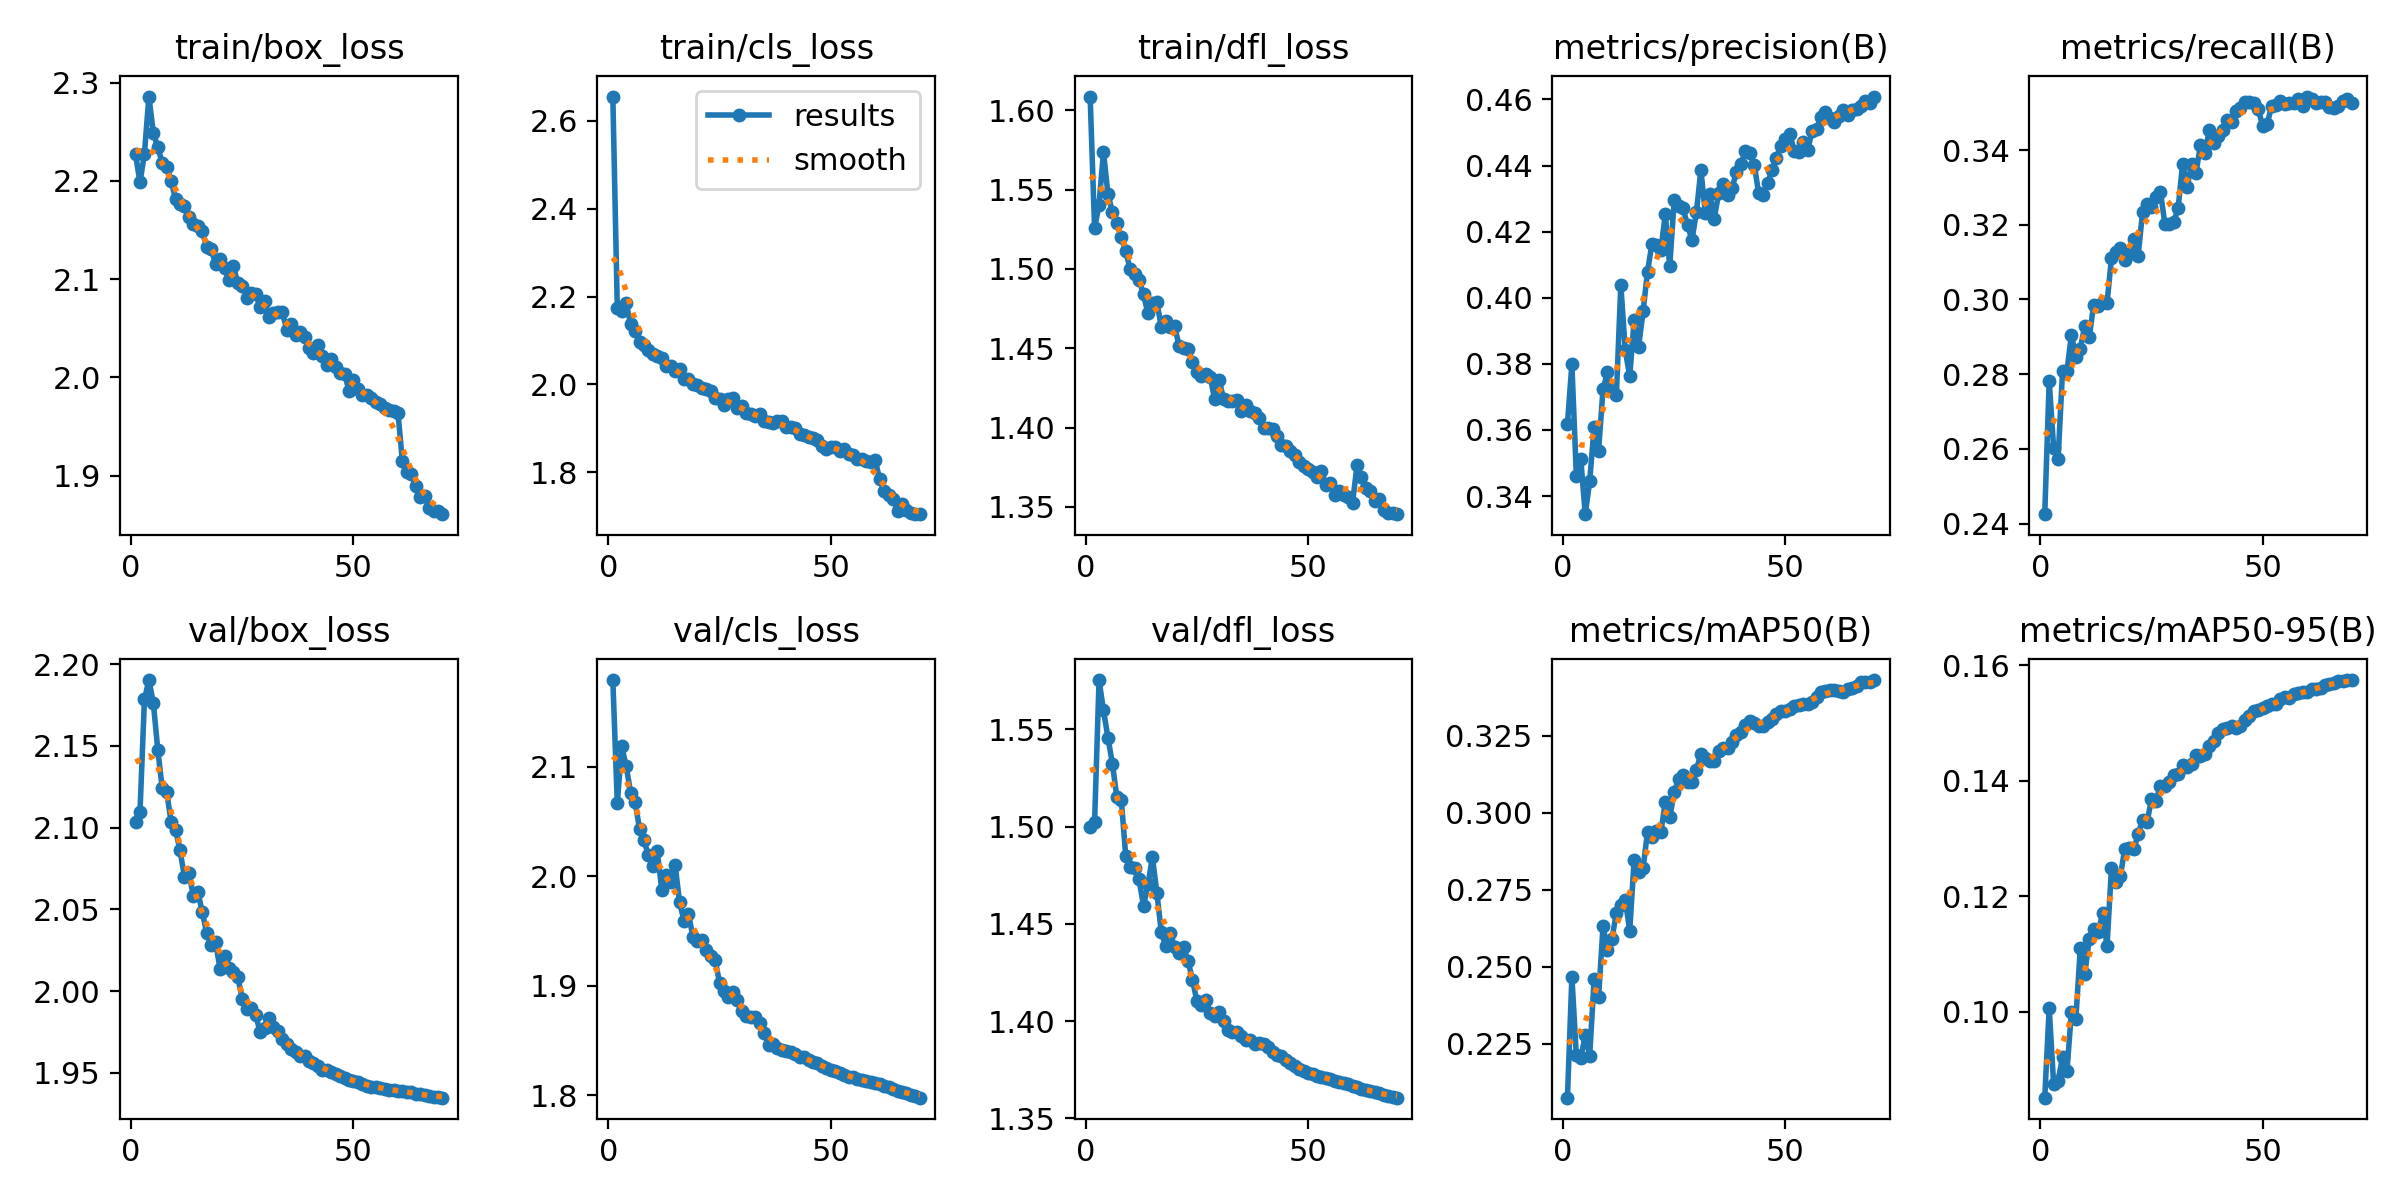

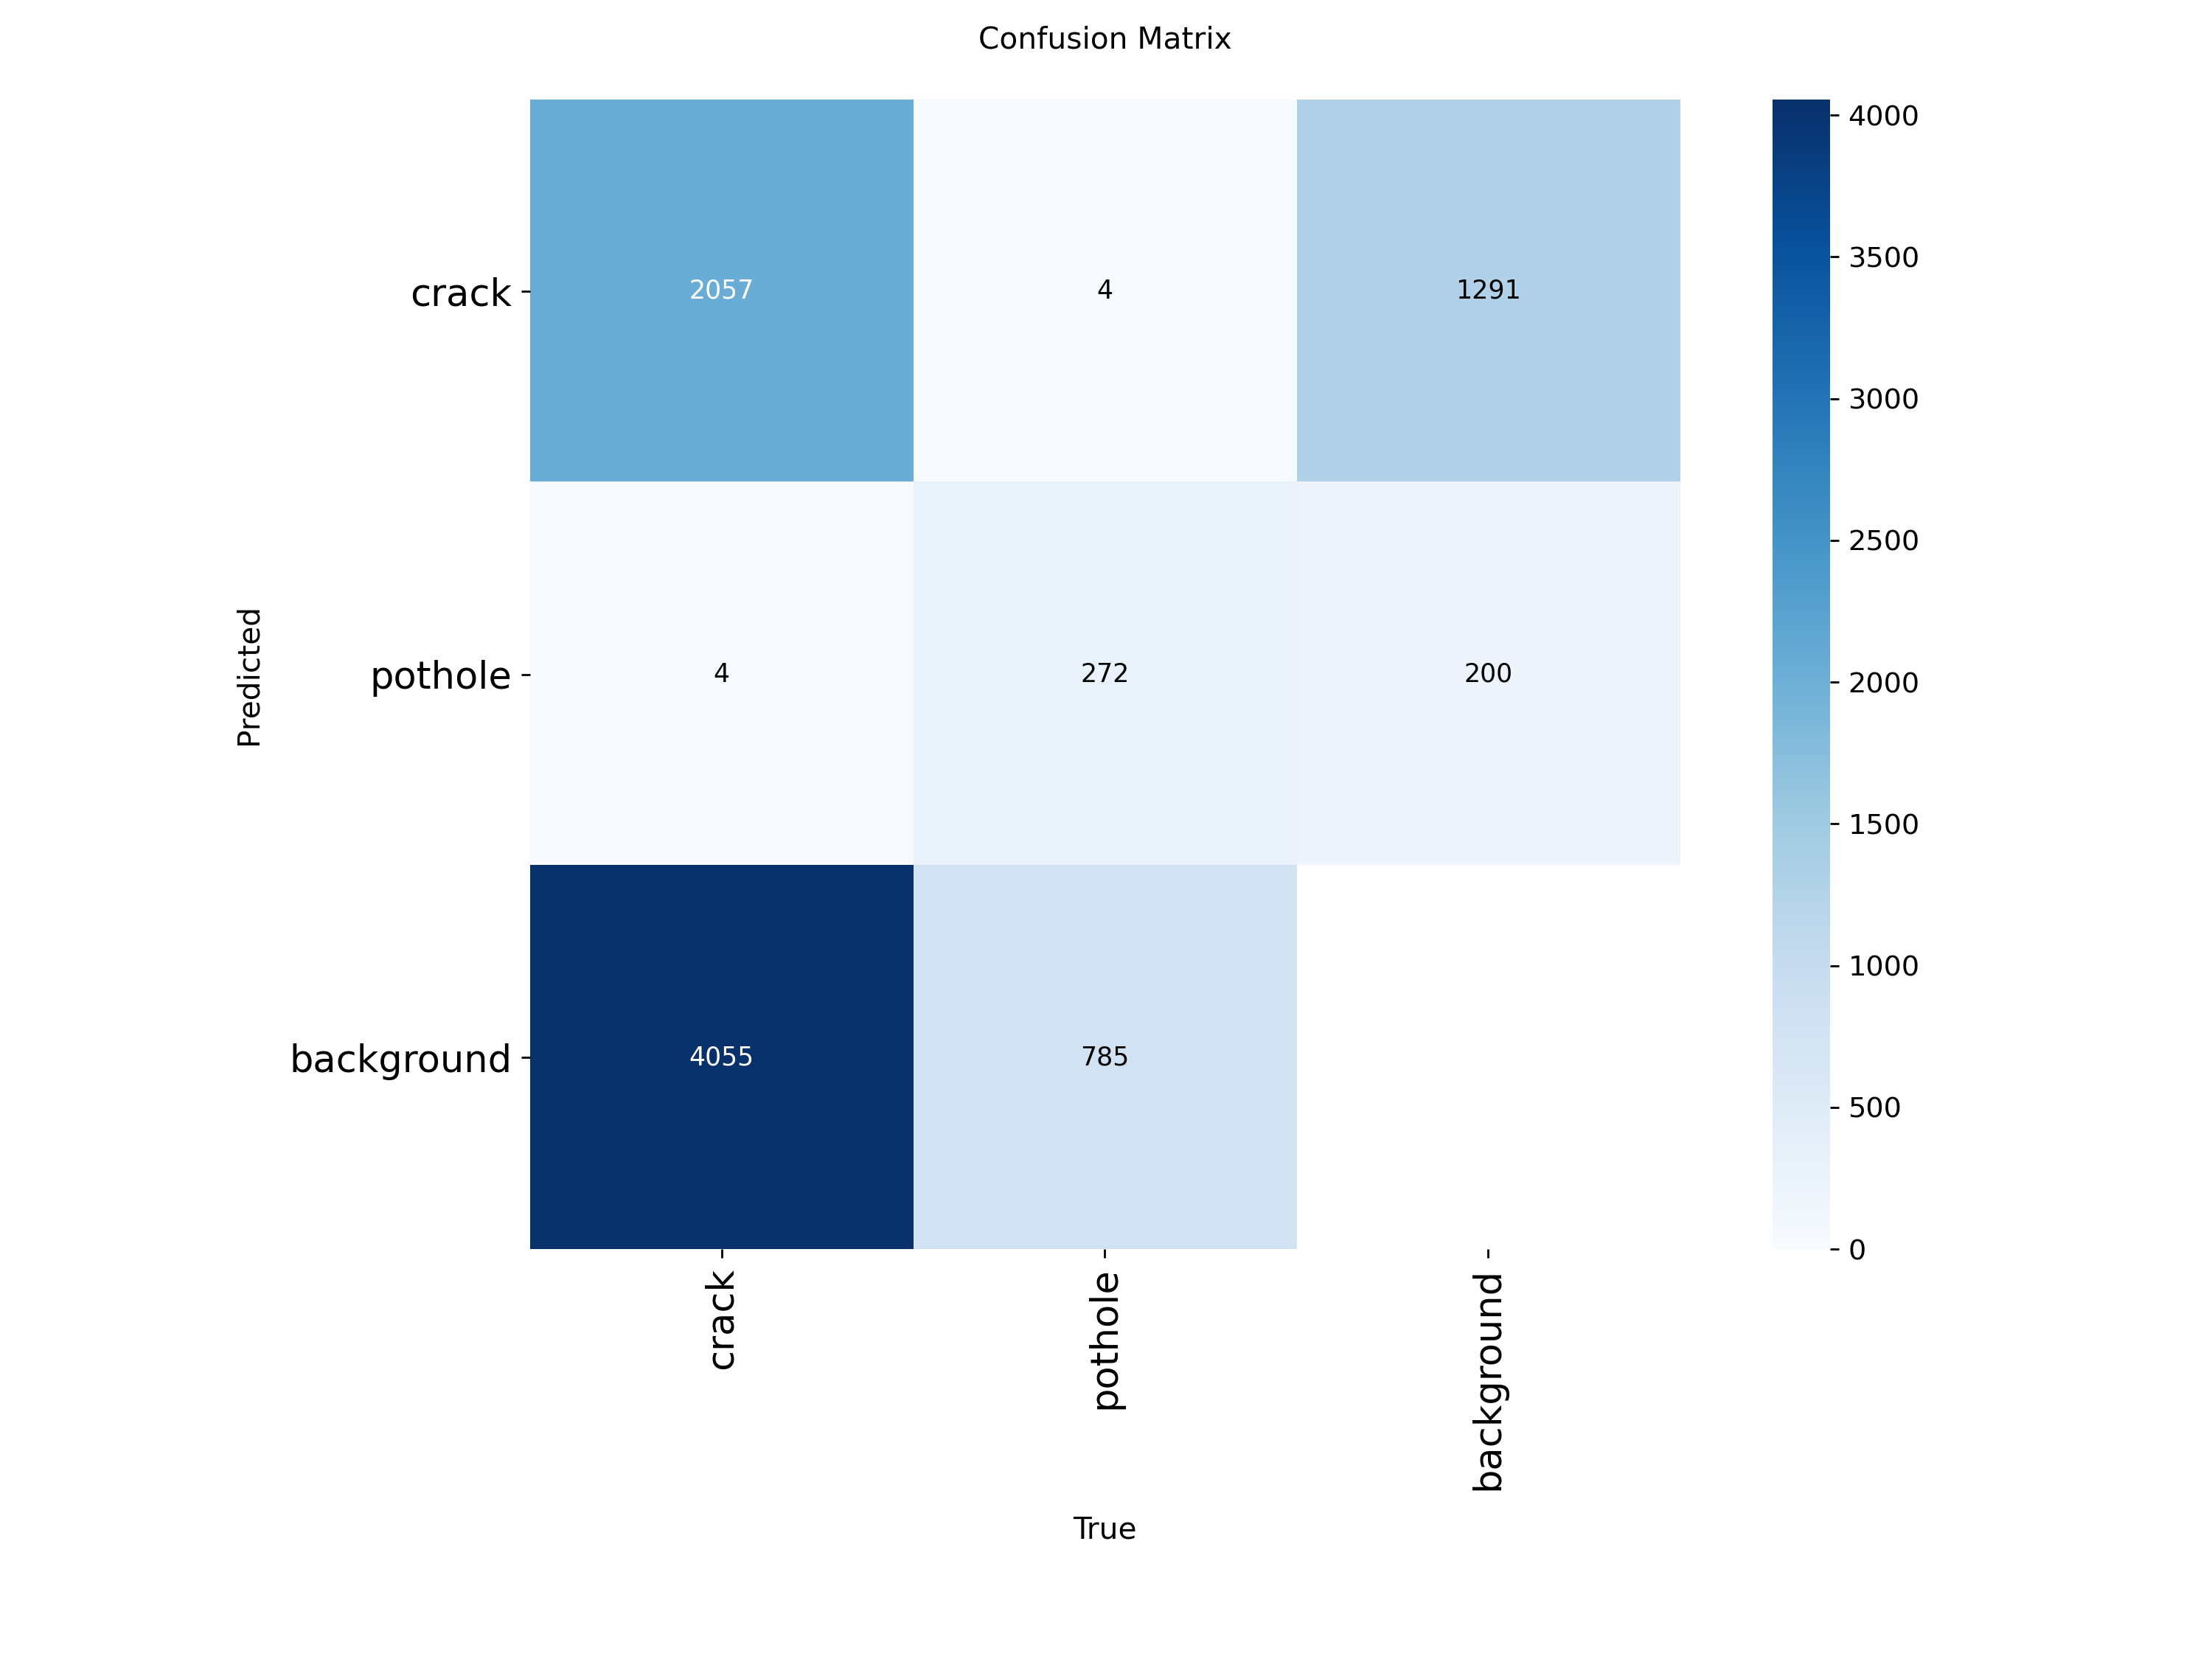

In [1]:
from IPython.display import Image, display
from pathlib import Path

RUN_DIR = Path("../../../runs/detect/yolov8n8_rdd2022_2class_256")

display(Image(filename=str(RUN_DIR / "results.png")))
display(Image(filename=str(RUN_DIR / "confusion_matrix.png")))


In [2]:
import pandas as pd

results_csv = RUN_DIR / "results.csv"
assert results_csv.exists(), "results.csv not found!"

df = pd.read_csv(results_csv)
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,lr/pg3,lr/pg4,lr/pg5,lr/pg6,lr/pg7
65,66,2880.29,1.87888,1.72889,1.35528,0.45719,0.35135,0.34099,0.15698,1.93649,1.80312,1.36284,0.002421,0.000807,0.002421,0.000807,0.002421,0.000807,0.002421,0.000807
66,67,2922.89,1.86749,1.71349,1.34824,0.45817,0.35193,0.34230,0.15721,1.93569,1.80194,1.36214,0.001997,0.000666,0.001997,0.000666,0.001997,0.000666,0.001997,0.000666
67,68,2965.88,1.86385,1.70676,1.34648,0.45945,0.35304,0.34238,0.15722,1.93532,1.80066,1.36168,0.001573,0.000524,0.001573,0.000524,0.001573,0.000524,0.001573,0.000524
68,69,3008.38,1.86426,1.70463,1.34615,0.45904,0.35377,0.34243,0.15743,1.93513,1.79933,1.36109,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383
69,70,3052.19,1.86078,1.70464,1.34546,0.46088,0.35268,0.34300,0.15745,1.93476,1.79798,1.36062,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241


In [3]:
final = df.iloc[-1]

print("Final metrics:")
print(f"Precision: {final['metrics/precision(B)']:.4f}")
print(f"Recall:    {final['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:   {final['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {final['metrics/mAP50-95(B)']:.4f}")

Final metrics:
Precision: 0.4609
Recall:    0.3527
mAP@0.5:   0.3430
mAP@0.5:0.95: 0.1575


In [4]:
# Calculate F1 score
precision = final['metrics/precision(B)']
recall = final['metrics/recall(B)']
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0.0

print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.3996


# Nano Model 320x320 int8 quantized

In [5]:
from ultralytics import YOLO

model = YOLO("/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite")

metrics = model.val(
    data="/home/saber/GitHub/road_anomaly_detection/data/rdd2class_yolo/rdd2class.yaml",
    imgsz=320
)

print(metrics.box.map)      # mAP50-95
print(metrics.box.map50)    # mAP50
print(metrics.box.mp)       # Precision
print(metrics.box.mr)       # Recall

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7799MiB)
Loading /home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite for TensorFlow Lite inference...
Setting batch=1 input of shape (1, 3, 320, 320)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 56.6±7.9 MB/s, size: 71.8 KB)
val: Scanning /home/saber/GitHub/road_anomaly_detection/data/rdd2class_yolo/labels/val.cache... 5120 images, 1670 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5120/5120 3.6Git/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5120/5120 90.8it/s 56.4s<0.1s
                   all       5120       7177      0.405      0.318       0.29      0.121
                 crack       3205       6116      0.447      0.338      0.331      0.143
               pothole        644       1061      0.362      0.299      0.249     0.0994
Speed

In [6]:
precision = metrics.box.mp
recall = metrics.box.mr

f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print("F1:", f1)

F1: 0.3563830678343654


In [15]:
from ultralytics import YOLO

model = YOLO(
    "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite"
)

results = model.predict(
    source="/home/saber/GitHub/road_anomaly_detection/data/videos/random_frames/frame_014.jpg",  # 👈 start with 1 image
    imgsz=640,
    conf=0.25,      # low for INT8
    iou=0.6,
    device="cpu",
    save=True,
    show=False
)

print("Detections:", len(results[0].boxes))


Loading /home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite for TensorFlow Lite inference...

image 1/1 /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames/frame_014.jpg: 320x320 (no detections), 9.1ms
Speed: 0.6ms preprocess, 9.1ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /home/saber/GitHub/road_anomaly_detection/runs/detect/predict11
Detections: 0


/home/saber/GitHub/road_anomaly_detection/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [19]:
from ultralytics import YOLO

model = YOLO(
    "/home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite"
)

results = model.predict(
    source="/home/saber/GitHub/road_anomaly_detection/data/videos/random_frames/frame_014.jpg",  # 👈 start with 1 image
    imgsz=320,
    conf=0.01,   # low for INT8
    iou=0.6,
    device="cpu",
    save=True,
    show=False
)

print("Detections:", len(results[0].boxes))




Loading /home/saber/GitHub/road_anomaly_detection/runs/detect/yolov8n8_rdd2022_2class5/weights/best_saved_model/best_full_integer_quant.tflite for TensorFlow Lite inference...

image 1/1 /home/saber/GitHub/road_anomaly_detection/data/videos/random_frames/frame_014.jpg: 320x320 1 crack, 2 potholes, 8.4ms
Speed: 0.6ms preprocess, 8.4ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /home/saber/GitHub/road_anomaly_detection/runs/detect/predict15
Detections: 3


# Nano Model 256x256 int8 quantized

In [7]:
from ultralytics import YOLO

model = YOLO("../../../runs/detect/yolov8n8_rdd2022_2class_256/weights/best_saved_model/best_full_integer_quant.tflite")

metrics = model.val(
    data="../../../data/rdd2class_yolo/rdd2class.yaml",
    imgsz=256
)

print(metrics.box.map)      # mAP50-95
print(metrics.box.map50)    # mAP50
print(metrics.box.mp)       # Precision
print(metrics.box.mr)       # Recall


Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7799MiB)


E0000 00:00:1771213049.220875    3009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771213049.233022    3009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771213049.329876    3009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771213049.329896    3009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771213049.329898    3009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771213049.329899    3009 computation_placer.cc:177] computation placer already registered. Please check linka

Loading ../../../runs/detect/yolov8n8_rdd2022_2class_256/weights/best_saved_model/best_full_integer_quant.tflite for TensorFlow Lite inference...
Setting batch=1 input of shape (1, 3, 256, 256)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 335.5±63.1 MB/s, size: 81.0 KB)
val: Scanning /home/saber/GitHub/road_anomaly_detection/data/rdd2class_yolo/labels/val.cache... 5120 images, 1670 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5120/5120 1.3Git/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 0% ──────────── 8/5120 22.7it/s 0.1s<3:45

/home/saber/GitHub/road_anomaly_detection/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5120/5120 112.8it/s 45.4s0.1ss
                   all       5120       7177      0.244      0.103       0.17     0.0874
                 crack       3205       6116      0.488      0.205       0.34      0.175
               pothole        644       1061          0          0          0          0
Speed: 0.1ms preprocess, 6.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /home/saber/GitHub/road_anomaly_detection/runs/detect/val
0.08741284848560811
0.17000400432328633
0.24397356143079316
0.1025997383911053


In [8]:
precision = metrics.box.mp
recall = metrics.box.mr

f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print("F1:", f1)

F1: 0.1444521178637201


# Infernece on nano model with img_size = 320

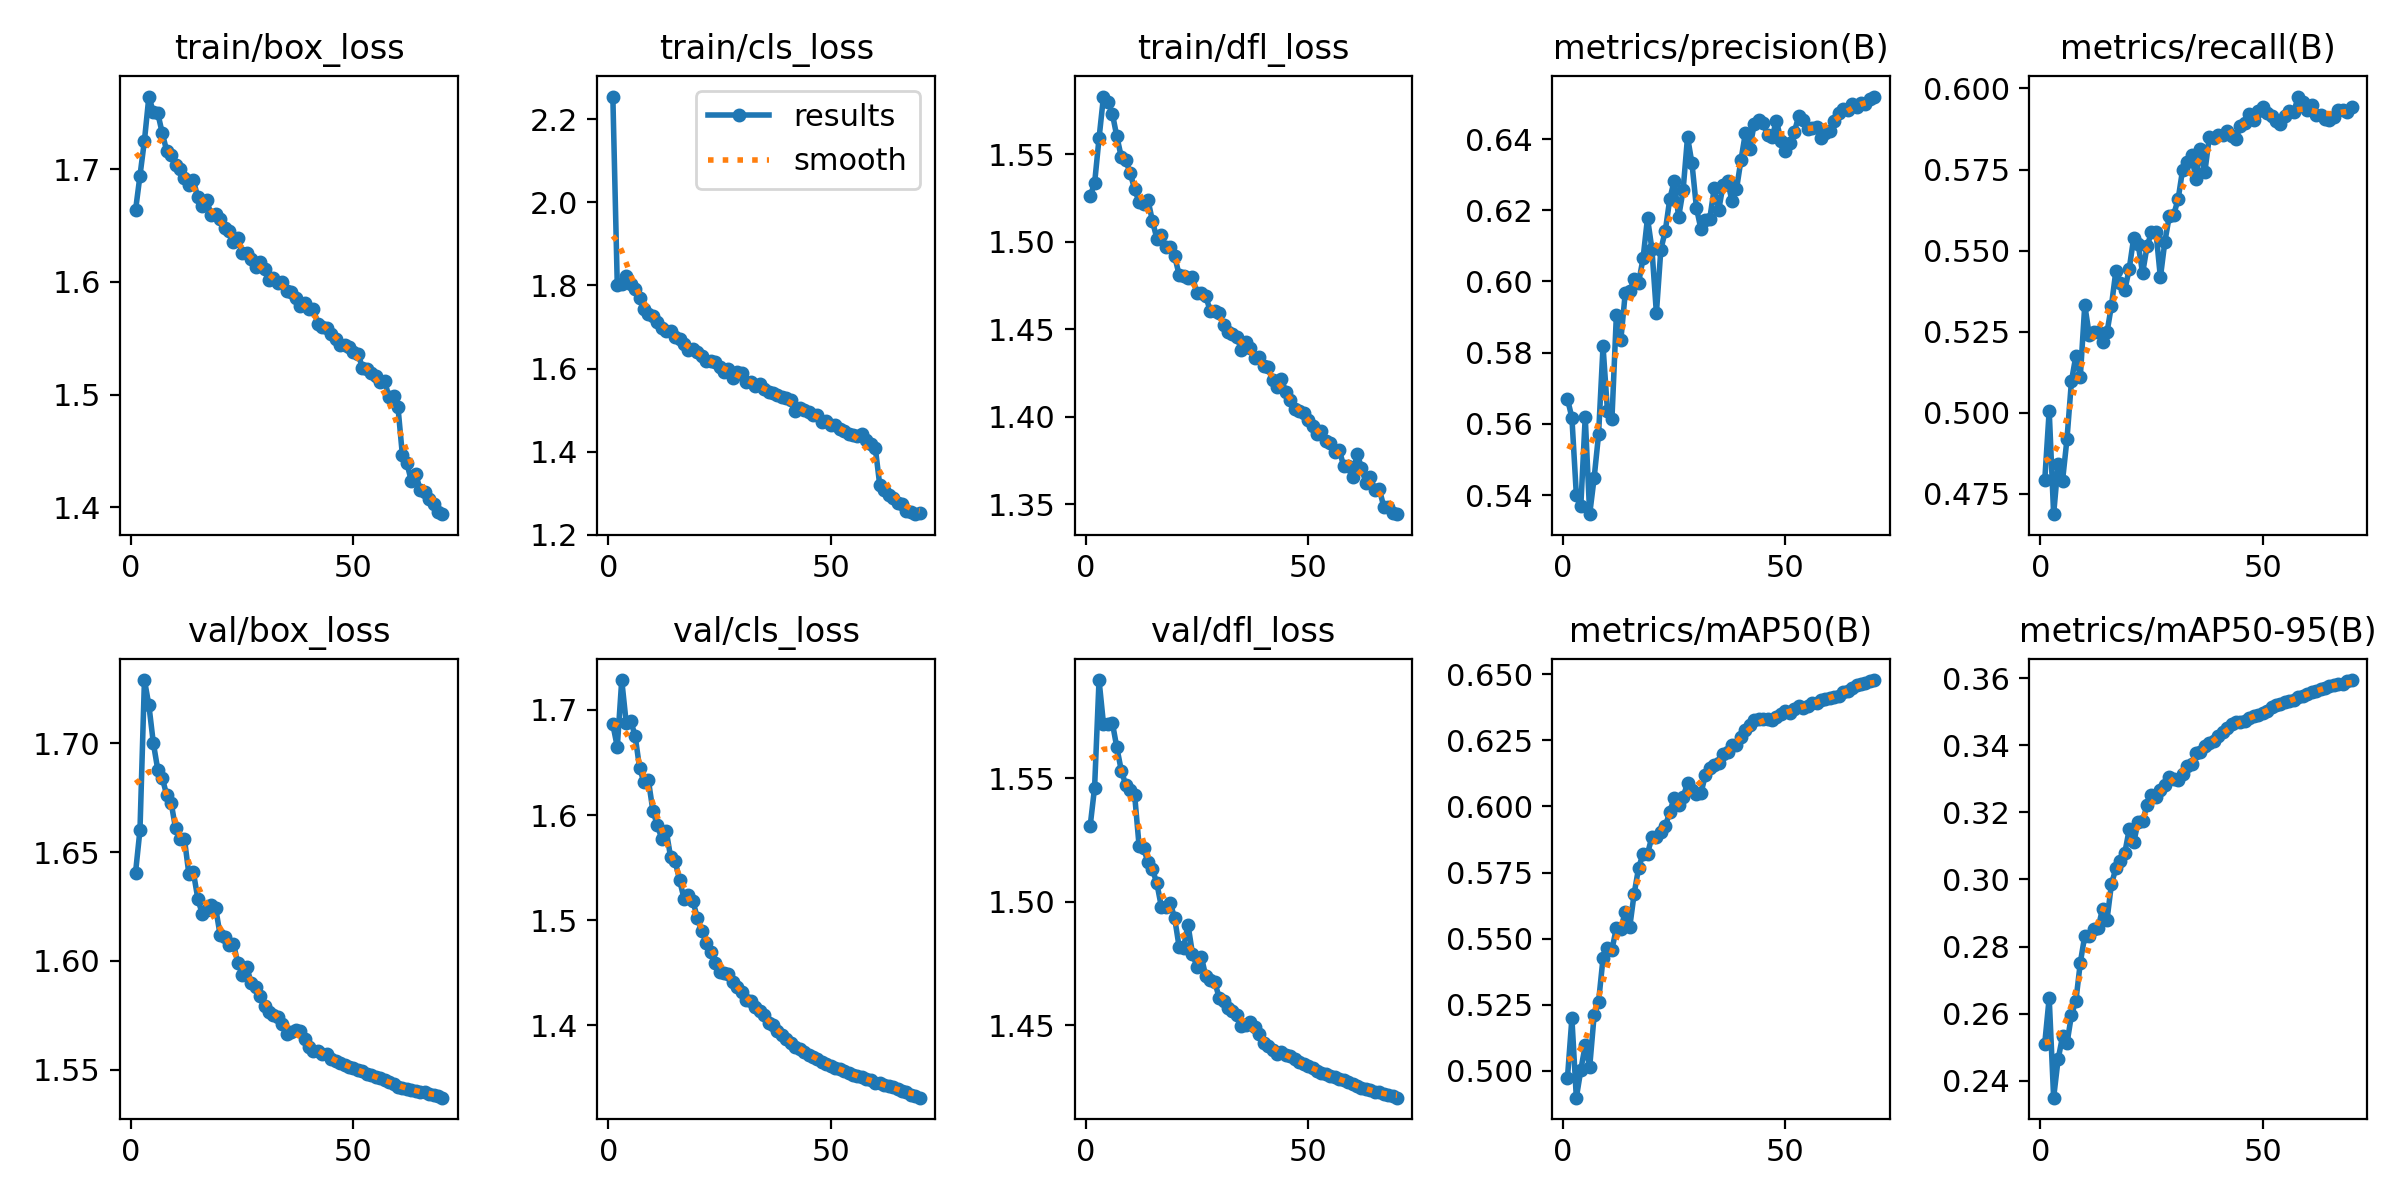

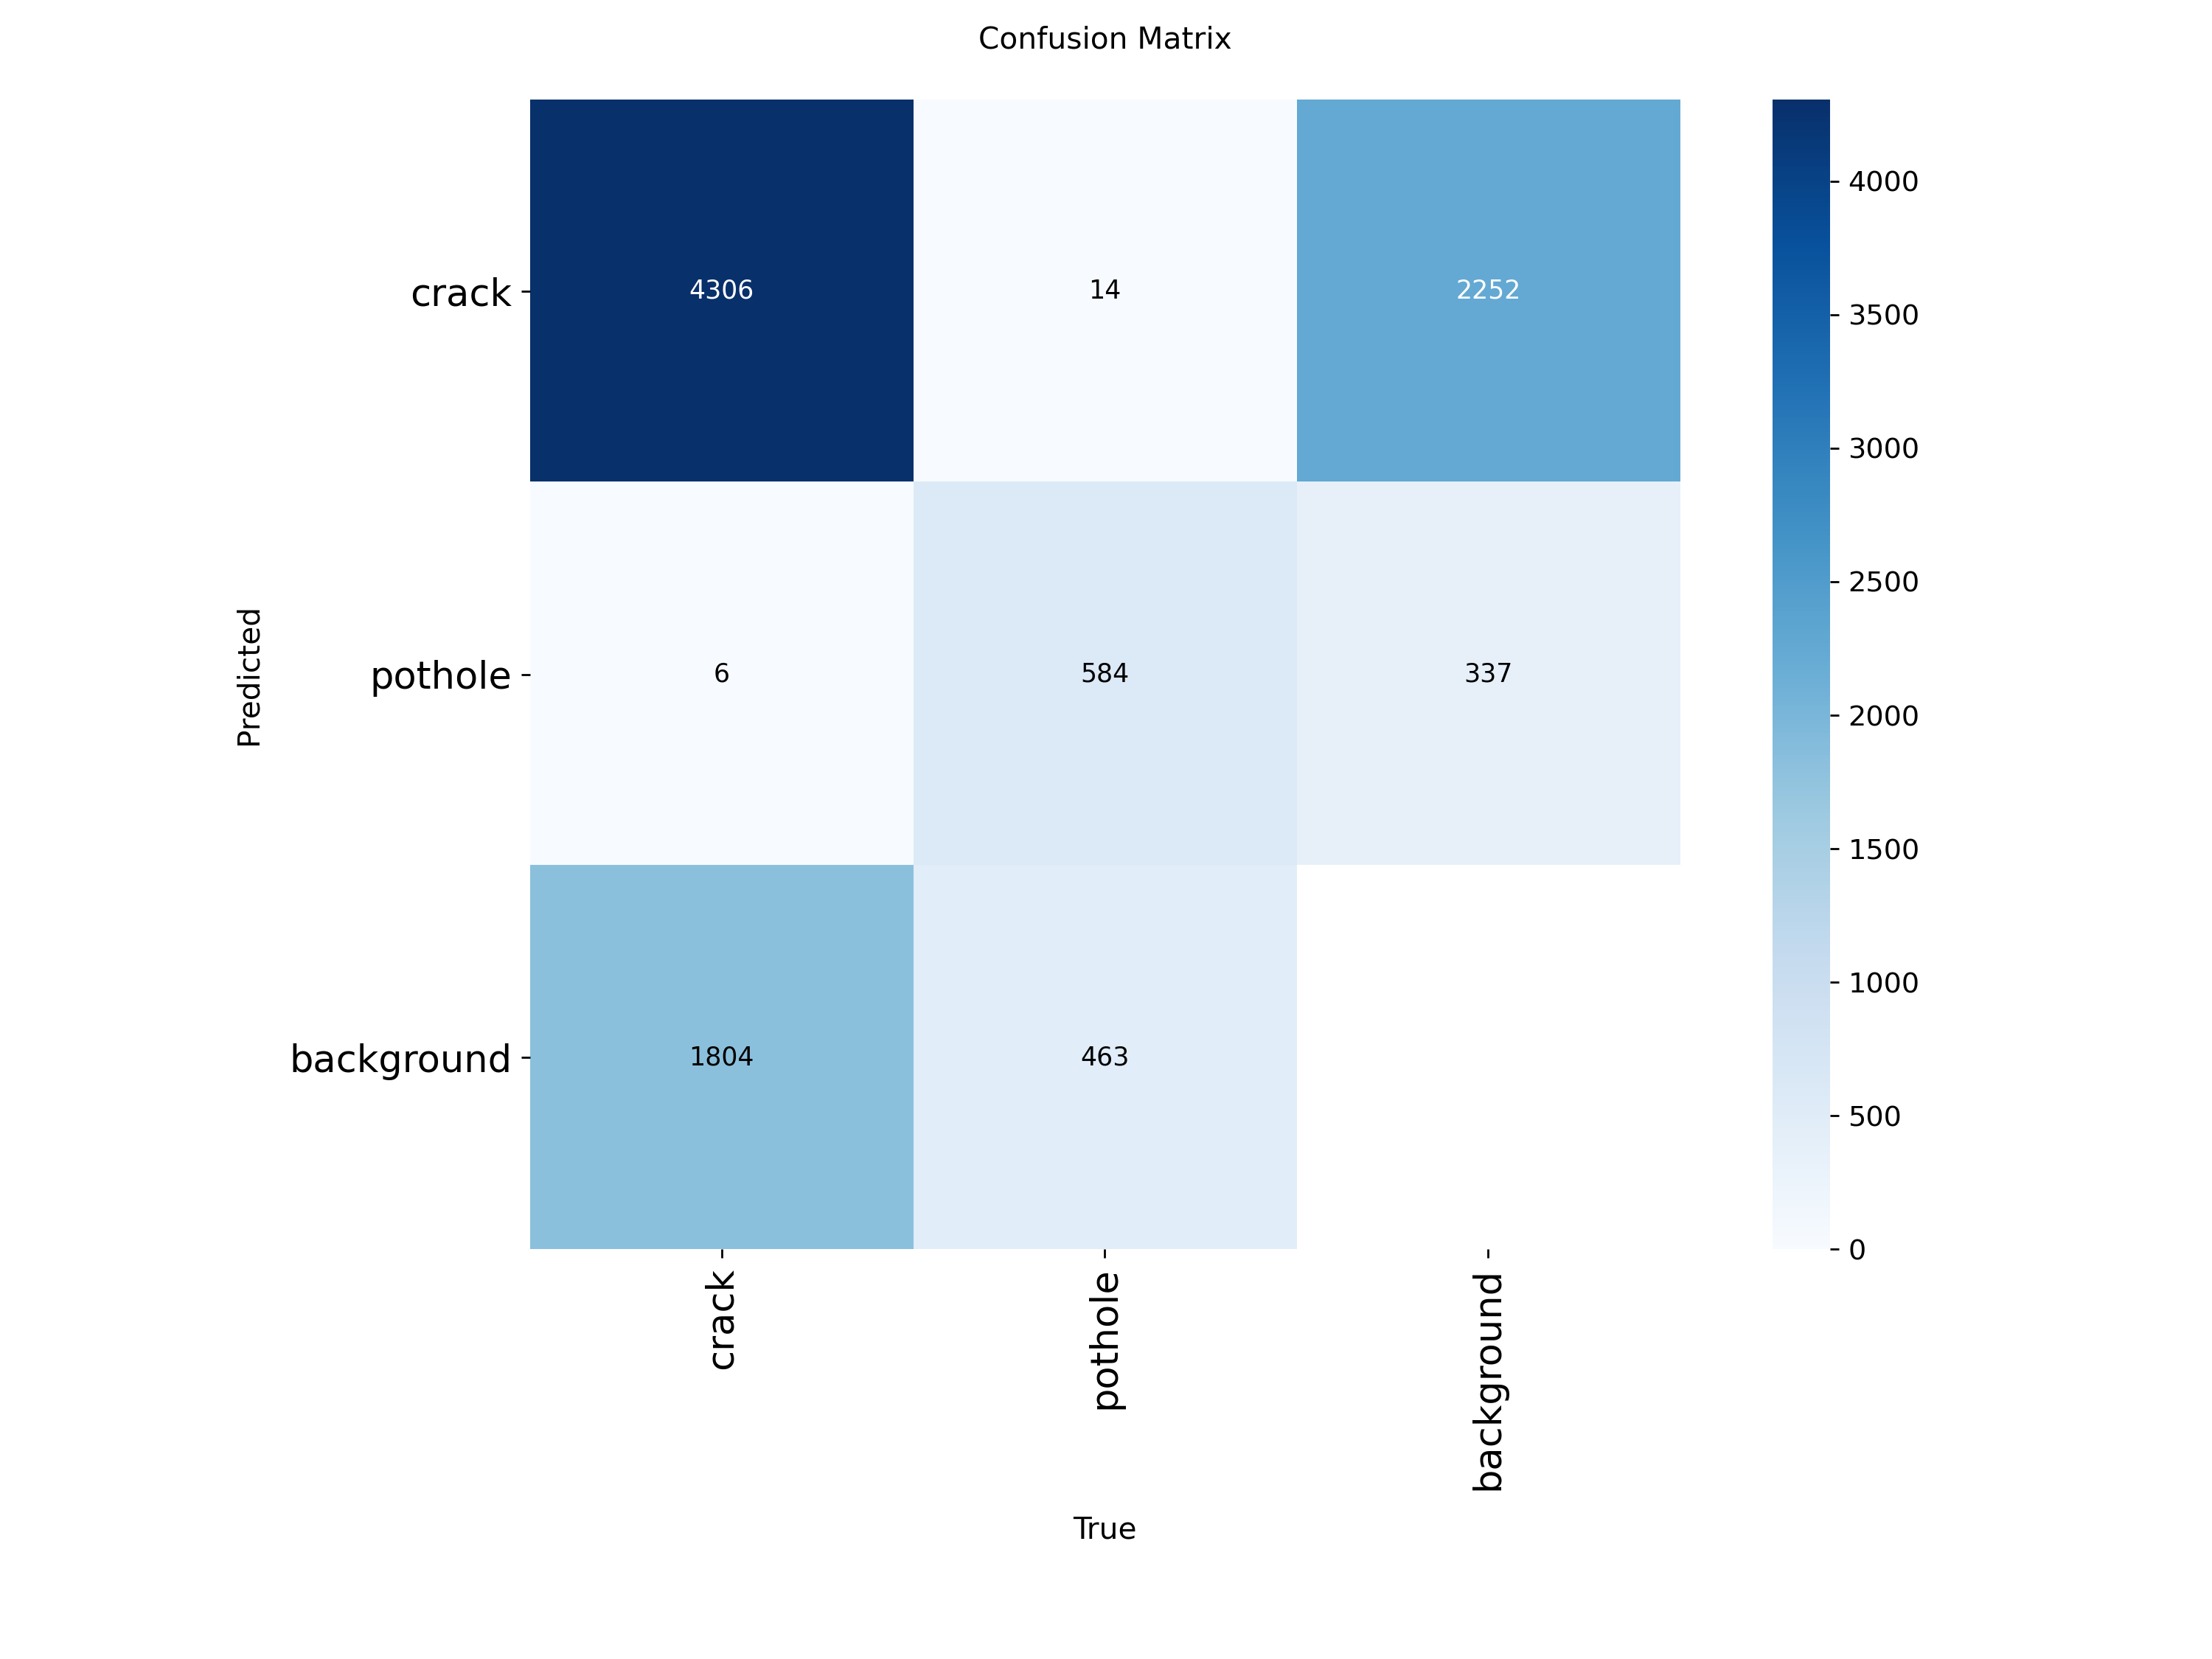

In [9]:
from IPython.display import Image, display
from pathlib import Path

RUN_DIR = Path("../../../runs/detect/yolov8n8_rdd2022_2class5")

display(Image(filename=str(RUN_DIR / "results.png")))
display(Image(filename=str(RUN_DIR / "confusion_matrix.png")))

In [10]:
import pandas as pd

results_csv = RUN_DIR / "results.csv"
assert results_csv.exists(), "results.csv not found!"

df = pd.read_csv(results_csv)
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,lr/pg3,lr/pg4,lr/pg5,lr/pg6,lr/pg7
65,66,7117.03,1.41404,1.27335,1.35869,0.64895,0.59126,0.64586,0.35797,1.53976,1.33769,1.42266,0.002421,0.000807,0.002421,0.000807,0.002421,0.000807,0.002421,0.000807
66,67,7220.99,1.40713,1.25756,1.34859,0.65012,0.59346,0.64650,0.35835,1.53897,1.33633,1.42197,0.001997,0.000666,0.001997,0.000666,0.001997,0.000666,0.001997,0.000666
67,68,7325.06,1.40324,1.25454,1.34827,0.64992,0.59332,0.64689,0.35838,1.53828,1.33427,1.42159,0.001573,0.000524,0.001573,0.000524,0.001573,0.000524,0.001573,0.000524
68,69,7429.21,1.39606,1.24973,1.34479,0.65125,0.59278,0.64765,0.35916,1.53773,1.33281,1.42120,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383,0.001149,0.000383
69,70,7533.28,1.39394,1.25257,1.34420,0.65193,0.59427,0.64787,0.35943,1.53713,1.33127,1.42053,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241,0.000724,0.000241


In [11]:
final = df.iloc[-1]

print("Final metrics:")
print(f"Precision: {final['metrics/precision(B)']:.4f}")
print(f"Recall:    {final['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:   {final['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {final['metrics/mAP50-95(B)']:.4f}")

Final metrics:
Precision: 0.6519
Recall:    0.5943
mAP@0.5:   0.6479
mAP@0.5:0.95: 0.3594


In [13]:
# Calculate F1 score
precision = final['metrics/precision(B)']
recall = final['metrics/recall(B)']
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0.0

print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.6218
